In [1]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from notebooks.core import constants
from notebooks.core import model_utils

In [2]:
df = pd.read_json("../../data/translated/emotions/equalized_emotions_dataset_pl.json")
df

,text,emotions,text_pl
0,i feel totally greedy,anger,Czuję się całkowicie chciwy
1,i feel so overwhelmed with emotions,fear,Czuję się tak przytłoczony emocjami
2,i didnt feel the g force effect i am stunned i...,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,ive just got to tell you all that im feeling r...,anger,ive just got to tell you all that I feel Racze...
4,i told you i was sorry you were feeling frustr...,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...,...
39995,im feeling quite generous lately as ive been w...,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,i feel like some of the characters dont deserv...,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,im feel fear within my bones that cant be shak...,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,ive been feeling more creative and less like a...,joy,Czułem się bardziej kreatywny i mniej jak czys...


In [3]:
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,anger,Czuję się całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,anger,ive just got to tell you all that I feel Racze...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...


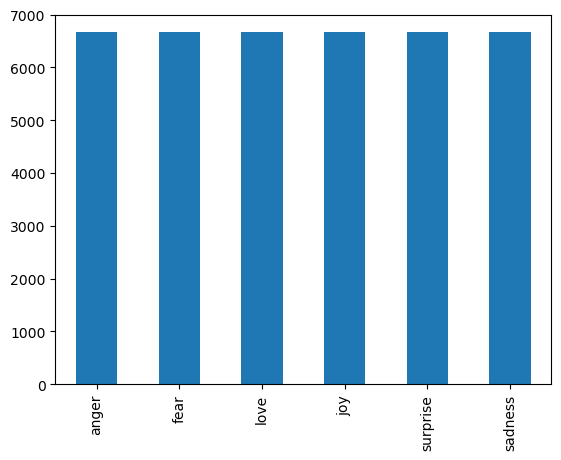

In [4]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [5]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [6]:
df = df.replace({"emotions": ordered_class_labels})

In [7]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['emotions', 'text_pl'],
    num_rows: 40000
})

In [8]:
from transformers import AutoTokenizer

MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

tokenizer.padding_side = "left"

In [9]:
def tokenize_function(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text_pl']]

    output = tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [10]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [11]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [12]:
from transformers import DataCollatorWithPadding

columns = ["input_ids", "attention_mask"]
label_cols = ["emotions"]
batch_size = 16
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
# Model parameters
training_number = 2
model_name = "emotions_pl_gpt2"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [14]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [15]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [16]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, use_cache=False, num_labels=6, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2ForSequenceClassification: ['transformer.h.0.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'lm_head.weight', 'transformer.h.6.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificat

In [17]:
model.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  4608      
_________________________________________________________________
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,444,416
Trainable params: 124,444,416
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
2000/2000 [==============================] - 329s 157ms/step - loss: 0.8336 - accuracy: 0.6734 - val_loss: 0.4234 - val_accuracy: 0.8528

Epoch 00001: saving model to ../../training_checkpoints\emotions_pl_gpt2\training_2\cp-0001.ckpt
Epoch 2/10
2000/2000 [==============================] - 307s 153ms/step - loss: 0.3220 - accuracy: 0.8837 - val_loss: 0.4084 - val_accuracy: 0.8583

Epoch 00002: saving model to ../../training_checkpoints\emotions_pl_gpt2\training_2\cp-0002.ckpt
Epoch 3/10
2000/2000 [==============================] - 307s 153ms/step - loss: 0.1998 - accuracy: 0.9260 - val_loss: 0.4496 - val_accuracy: 0.8625

Epoch 00003: saving model to ../../training_checkpoints\emotions_pl_gpt2\training_2\cp-0003.ckpt
Epoch 4/10
2000/2000 [==============================] - 307s 154ms/step - loss: 0.1338 - accuracy: 0.9463 - val_loss: 0.5764 - val_accuracy: 0.8495

Epoch 00004: saving model to ../../training_checkpoints\emotions_pl_gpt2\training_2\cp-0004.ckpt
Epoch 5/10
2000/

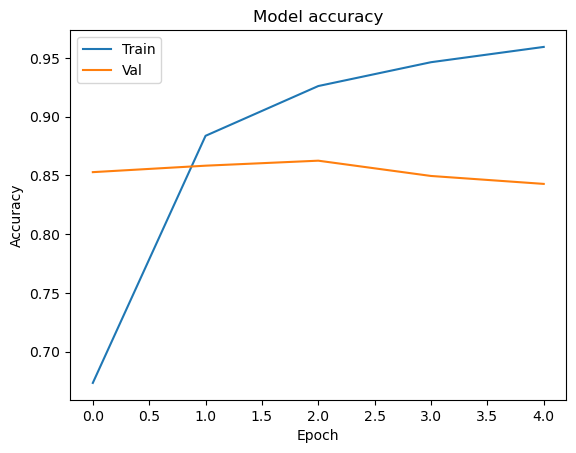

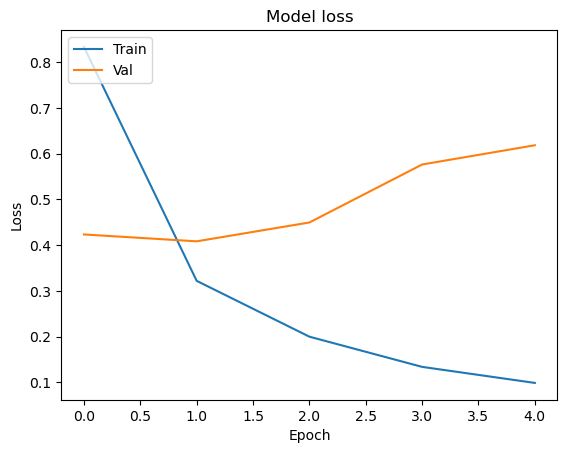

In [20]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [21]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [22]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\emotions_pl_gpt2_2\1\assets


INFO:tensorflow:Assets written to: ../../trained_models\emotions_pl_gpt2_2\1\assets


In [23]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

250/250 [==============================] - 24s 95ms/step - loss: 0.4246 - accuracy: 0.8565


[0.42463135719299316, 0.8565000295639038]

In [24]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

In [25]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['emotions'],
    class_preds=class_preds,
    average='micro'
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.8565
Recall score:  0.8565
F1 score:  0.8565


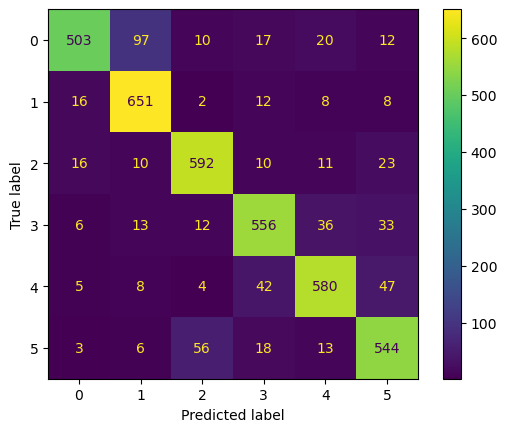

In [26]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [27]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['text_pl'],
                                              class_actual=raw_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Nie czułem efektu siły g Jestem oszołomiony Poszedłem na tę przejażdżkę z moimi przyjaciółmi
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 2
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: ive just got to tell you all that I feel Raczej niecierpliwy
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Powiedziałem ci, że przepraszam, że czujesz się sfrustrowany i zapytałem, czy myślisz, że krzyk zmieni moje zdanie
            - PREDICTED VALUE: 5
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Czuję się nieco niepewnie prosząc o pomoc w pomaganiu mi w finansowaniu tej podróży, ponieważ wydaje się to bardzo pobłażliwą rzeczą, którą można poprosić o pomoc.
            - PREDICTED VALUE: 1
            - C

In [28]:
tokenized_test_dataset

Dataset({
    features: ['emotions', 'text_pl', 'input_ids', 'attention_mask'],
    num_rows: 4000
})

In [29]:
test_df = pd.DataFrame(
    list(zip(tokenized_test_dataset['text_pl'], tokenized_test_dataset['emotions'], class_preds)),
    columns=['text_pl', 'emotions', 'prediction'])
test_df

,text_pl,emotions,prediction
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,5
...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2


In [30]:
def map_token_counts(row):
    return len(row['text_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotions'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text_pl,emotions,prediction,token_count,count_belonging,correctly_predicted
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5,13,12-17,1
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5,21,18-23,1
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1,16,12-17,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2,11,6-11,1
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,5,17,12-17,0
...,...,...,...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0,6,6-11,1
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4,12,12-17,1
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5,22,18-23,0
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2,9,6-11,1


In [31]:
test_df = test_df.drop(test_df[test_df.token_count > 23].index)

In [32]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

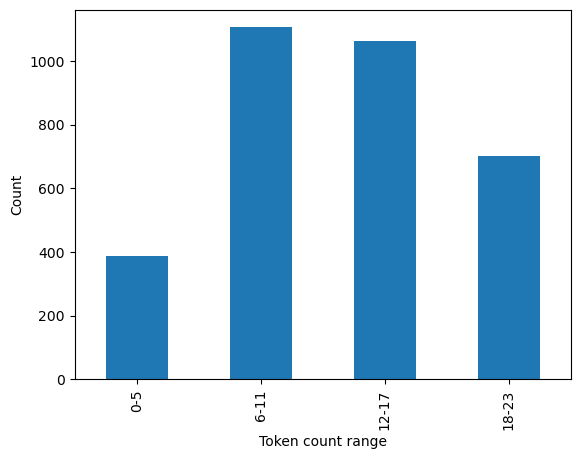

In [33]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [34]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0.}

In [35]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 333, '6-11': 967, '12-17': 935, '18-23': 580}
Element count:  {'0-5': 386, '6-11': 1106, '12-17': 1064, '18-23': 702}
Accuracies:  {'0-5': 0.8626943005181347, '6-11': 0.8743218806509946, '12-17': 0.8787593984962406, '18-23': 0.8262108262108262}


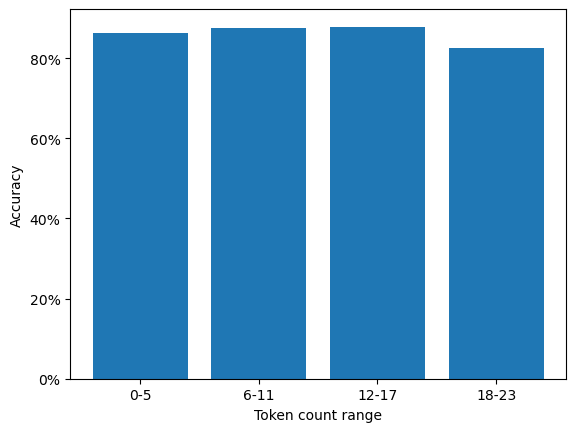

In [36]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()